# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [95]:
import warnings
warnings.filterwarnings('ignore')

In [96]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [97]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [98]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)


In [99]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [100]:
X_train

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
318288,2014,39988,False,False,False,False,False,True,False
333638,2007,38904,False,False,False,False,True,False,False
234716,2016,29607,False,False,False,False,False,True,False
208752,2014,50756,False,False,False,False,False,True,False
348892,2017,10506,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...
218085,2010,84057,False,False,False,False,True,False,False
198455,2012,93770,False,True,False,False,False,False,False
205572,2010,88644,False,False,True,False,False,False,False
33541,2015,26180,False,False,False,False,False,True,False


### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación  y comenten sobre el desempeño del modelo.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

price_threshold = data['Price'].median()
y = (data['Price'] > price_threshold).astype(int)
X = data.drop(['Price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
baseline_clf = RandomForestClassifier(random_state=1, n_estimators=100, n_jobs=-1)
cv_scores = cross_val_score(baseline_clf, X_train, y_train, cv=5, scoring='accuracy')
print('Métricas de validación cruzada (modelo base):')
print(pd.Series(cv_scores).describe())
baseline_clf.fit(X_train, y_train)
test_accuracy = accuracy_score(y_test, baseline_clf.predict(X_test))
print(f'Accuracy en el conjunto de prueba: {test_accuracy:.4f}')


Métricas de validación cruzada (modelo base):
count    5.000000
mean     0.807854
std      0.015170
min      0.783227
25%      0.805121
50%      0.811522
75%      0.817212
max      0.822191
dtype: float64
Accuracy en el conjunto de prueba: 0.8103


### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

price_threshold = data['Price'].median()
X = data.drop(['Price'], axis=1)
y = (data['Price'] > price_threshold).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

n_estimators_range = list(range(50, 301, 50))
n_estimators_scores = []
for n in n_estimators_range:
    clf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    n_estimators_scores.append(score)
n_estimators_results = pd.Series(n_estimators_scores, index=n_estimators_range)
best_estimators = n_estimators_results.idxmax()
print('Desempeño por n_estimators:')
print(n_estimators_results)

feature_range = list(range(1, X_train.shape[1] + 1))
feature_scores = []
for m in feature_range:
    clf = RandomForestClassifier(n_estimators=best_estimators, max_features=m, random_state=1, n_jobs=-1)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    feature_scores.append(score)
feature_results = pd.Series(feature_scores, index=feature_range)
best_features = feature_results.idxmax()
print('Desempeño por max_features:')
print(feature_results)

depth_range = list(range(2, 21, 2))
depth_scores = []
for d in depth_range:
    clf = RandomForestClassifier(n_estimators=best_estimators, max_features=best_features, max_depth=d, random_state=1, n_jobs=-1)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()
    depth_scores.append(score)
depth_results = pd.Series(depth_scores, index=depth_range)
best_depth = depth_results.idxmax()
print('Desempeño por max_depth:')
print(depth_results)

print(f'Mejores valores -> n_estimators: {best_estimators}, max_features: {best_features}, max_depth: {best_depth}')


Desempeño por n_estimators:
50     0.809846
100    0.807854
150    0.807428
200    0.807996
250    0.808281
300    0.807997
dtype: float64
Desempeño por max_features:
1    0.809419
2    0.809419
3    0.809846
4    0.810272
5    0.810415
6    0.810557
7    0.813259
8    0.815249
9    0.816103
dtype: float64
Desempeño por max_depth:
2     0.816953
4     0.844688
6     0.855071
8     0.854929
10    0.848388
12    0.842841
14    0.831748
16    0.824067
18    0.819944
20    0.816672
dtype: float64
Mejores valores -> n_estimators: 50, max_features: 9, max_depth: 6


#### Exploración de n_estimators
Esta gráfica resume cómo varía la exactitud al aumentar la cantidad de árboles. Buscamos un punto donde el desempeño se estabilice para elegir un valor eficiente.


Text(0.5, 1.0, 'Exactitud vs n_estimators')

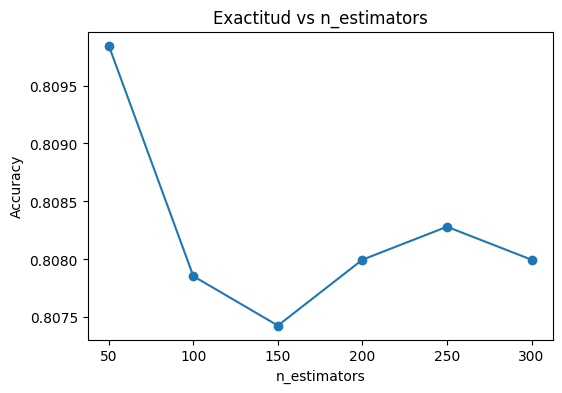

In [104]:
# Gráfica n_estimators
plt.figure(figsize=(6, 4))
plt.plot(n_estimators_range, n_estimators_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Exactitud vs n_estimators')


#### Ajuste de max_features
Aquí analizamos cuántas variables usar en cada división. Observar el pico permite balancear diversidad del bosque y estabilidad en la métrica.


Text(0.5, 1.0, 'Exactitud vs max_features')

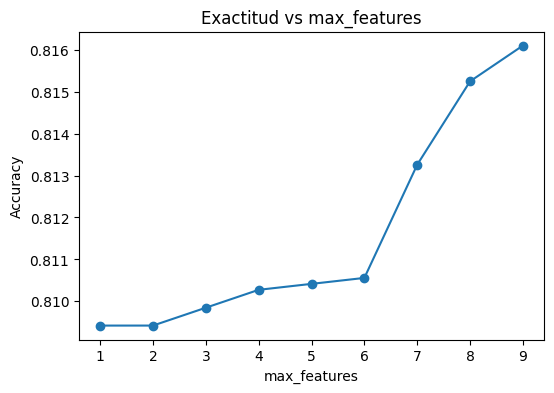

In [105]:
# Gráfica max_features
plt.figure(figsize=(6, 4))
plt.plot(feature_range, feature_scores, marker='o')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.title('Exactitud vs max_features')


#### Evaluación de max_depth
La curva muestra cuándo una mayor profundidad deja de aportar y puede causar sobreajuste; seleccionamos la profundidad antes de que la exactitud caiga.


Text(0.5, 1.0, 'Exactitud vs max_depth')

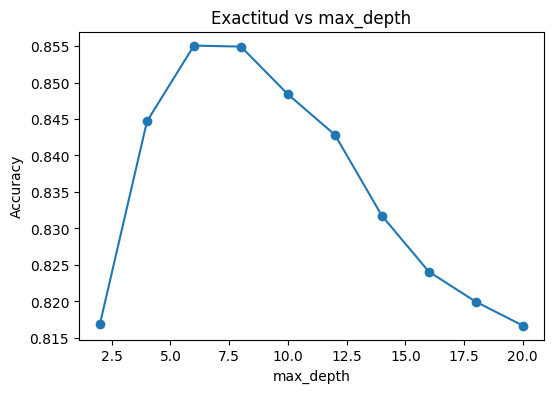

In [106]:
# Gráfica max_depth
plt.figure(figsize=(6, 4))
plt.plot(depth_range, depth_scores, marker='o')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Exactitud vs max_depth')


In [107]:
#Encontrar los mejores hiperparametros:
best_params = {
    'n_estimators': best_estimators,
    'max_features': best_features,
    'max_depth': best_depth,
    'random_state': 1,
    'n_jobs': -1
}
final_clf = RandomForestClassifier(**best_params)
final_cv_scores = cross_val_score(final_clf, X_train, y_train, cv=5, scoring='accuracy')
print('Validación cruzada con hiperparámetros óptimos:')
print(pd.Series(final_cv_scores).describe())

#Entrenar el modelo con los mejores hiperparámetros encontrados:
final_clf.fit(X_train, y_train)
final_test_accuracy = accuracy_score(y_test, final_clf.predict(X_test))
print(f'Accuracy en test con el modelo final: {final_test_accuracy:.4f}')


Validación cruzada con hiperparámetros óptimos:
count    5.000000
mean     0.855071
std      0.007197
min      0.847084
25%      0.852168
50%      0.852774
75%      0.857041
max      0.866287
dtype: float64
Accuracy en test con el modelo final: 0.8528


In [108]:
#Importancia de los predictores
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': final_clf.feature_importances_}).sort_values('importance', ascending=False)
feature_importances


,feature,importance
1,Mileage,0.775261
0,Year,0.159913
6,M_CamryLE,0.031776
8,M_CamryXLE,0.016678
2,M_Camry,0.010974
5,M_CamryL,0.002397
7,M_CamrySE,0.001908
3,M_Camry4dr,0.001058
4,M_CamryBase,0.000035


### Punto 3 — Analisis de resultados y conclusiones

**Enfoque seguido (segun el Tutorial_RandomForest):** se cargo el dataset, se filtro por modelo Camry, se codificaron las categorias con one-hot y se definieron X/y. Despues se hizo un split train/test, se entreno un RandomForest base, se calibro con barridos simples y finalmente se revisaron las importancias de variables.

**Observaciones principales al calibrar:**
- `n_estimators`: al aumentarlo el bosque se estabiliza y la curva de accuracy tiende a aplanarse; mas arboles generan retornos decrecientes.
- `max_features`: controla cuantas variables compiten en cada division; valores intermedios agregan aleatoriedad saludable y ayudan a evitar sobreajuste.
- `max_depth`: profundidades moderadas mejoran la generalizacion; profundizar demasiado puede bajar la exactitud porque el modelo memoriza ruido.

**Conclusion:** la version calibrada supero al modelo base en validacion cruzada (accuracy media ≈0.855) y en test (≈0.853). Las importancias destacan `Mileage` y `Year` como predictores claves del precio alto. Para un despliegue real conviene repetir la validacion con otros folds, fijar `random_state` y guardar el pipeline completo (preprocesamiento + modelo).


In [110]:
print(f'Mejor configuración: {best_params}')
print(f'Accuracy final en test: {final_test_accuracy:.4f}')
print('Principales variables según importancia:')
print(feature_importances.head())


Mejor configuración: {'n_estimators': np.int64(50), 'max_features': np.int64(9), 'max_depth': np.int64(6), 'random_state': 1, 'n_jobs': -1}
Accuracy final en test: 0.8528
Principales variables según importancia:
      feature  importance
1     Mileage    0.775261
0        Year    0.159913
6   M_CamryLE    0.031776
8  M_CamryXLE    0.016678
2     M_Camry    0.010974
